Github Memento Tutorial
scMemento: https://github.com/yelabucsf/scrna-parameter-estimation/blob/master/tutorials/ifn_mono.ipynb


In [1]:
# # This is only for development purposes

# import sys
# sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.3-py3.7.egg')
# import memento


Bad key "text.kerning_factor" on line 4 in
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import scanpy as sc
import memento
import numpy as np
import seaborn as sns
from scipy.sparse import csr_matrix
import logging
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 
import statsmodels
import pickle

In [3]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, frameon=True, vector_friendly=True, fontsize=14, figsize=None, color_map=None, 
                     format='png', facecolor=None, transparent=True, ipython_format='png2x')
sc.settings.figdir = '../data/covid/figures'

In [4]:
fig_path = '../data/covid/figures'
data_path = '../data/covid'

In [5]:
# creating dictionary for average sequencing saturations
q = {}

#Take the average sequencing saturation for run1:
s1 = (0.712 + 0.745 + 0.748 + 0.728 + 0.687 + 0.703)/6
# and multiply this with 0.15 for 5'-end v2 data:
q['run1'] = s1 * 0.15

# Run2
s2 = (0.692 + 0.724 + 0.737 + 0.664 + 0.697 + 0.695)/6
q['run2'] = s2 * 0.15

# Run3
s3 = (0.86 + 0.816 + 0.857 + 0.874 + 0.863 + 0.917)/6
q['run3'] = s3 * 0.15

# Run4
s4 = (0.79 + 0.776 + 0.796 + 0.759)/4
q['run4'] = s4 * 0.15

# Run5
s5 = (0.708 + 0.723 + 0.776 + 0.701 + 0.749 + 0.746)/6
q['run5'] = s5 * 0.15

# Run7
s7 = (0.791 + 0.787 + 0.815 + 0.812 + 0.777 + 0.758)/6
q['run7'] = s7 * 0.15

# Run8
s8 = (0.659 + 0.688 + 0.690 + 0.656 + 0.622 + 0.649)/6
q['run8'] = s8 * 0.15

# Run9
s9 = (0.753 + 0.730 + 0.726 + 0.735 + 0.730 + 0.748)/6
q['run9'] = s9 * 0.15

# Run10
s10 = (0.797 + 0.787 + 0.776 + 0.773)/4
q['run10'] = s10 * 0.15

q_sum = 0
for key in q.keys():
    q_sum = q_sum + q[key]
q_avg = q_sum / len(q)

In [6]:
#Input should be raw count matrix. Preferrably, feed the one with all genes so that we can choose what genes to look at.
adata = sc.read('/data_volume/covid/run1to10_final_assigned3_useonlyRaw.h5ad',cache=True)

In [7]:
# changing COVID_status to 0, -1, or 1 for healthy(None), COVID-, and COVID+ respectively
adata.obs['COVID_status'] = adata.obs['COVID_status'].cat.add_categories([-1,0, 1])
adata.obs.loc[adata.obs['COVID_status'] == 'None', 'COVID_status'] = 0
adata.obs.loc[adata.obs['COVID_status'] == 'Negative', 'COVID_status'] = -1
adata.obs.loc[adata.obs['COVID_status'] == 'Positive', 'COVID_status'] = 1

In [8]:
# removing cells with COVID_status nan
adata = adata[adata.obs['COVID_status'] != 'nan']

In [9]:
# filtering out COVID-
adata = adata[adata.obs['COVID_status'] != -1]

### Iterating through each cell type and conducting memento on healthy vs COVID+ for each timepoint

In [10]:
timepoints = ["0", "4", "7", "14"]

In [11]:
cell_types = np.unique(adata.obs['cell_type'])

In [12]:
cell_types

array(['B', 'NK', 'NKT', 'Progen', 'Prolif', 'T4', 'T8', 'Tgd', 'cDC',
       'cM', 'ncM', 'pDC', 'plasma_B'], dtype=object)

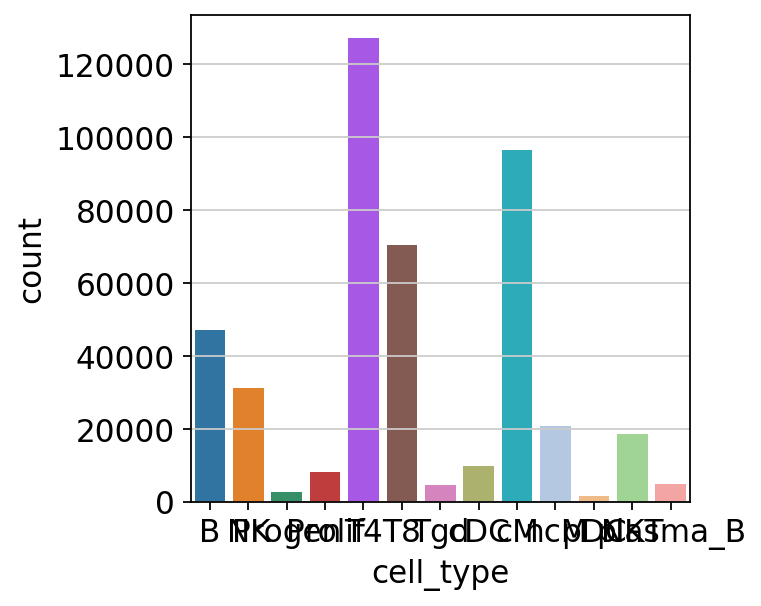

In [13]:
sns.countplot(x=adata.obs['cell_type'])

In [14]:
# splitting by timepoint and including healthy controls
adata_times = []
for time in timepoints:
    adata_times.append(adata[(adata.obs["timepoint"] == time) | (adata.obs['COVID_status'] == 0)])

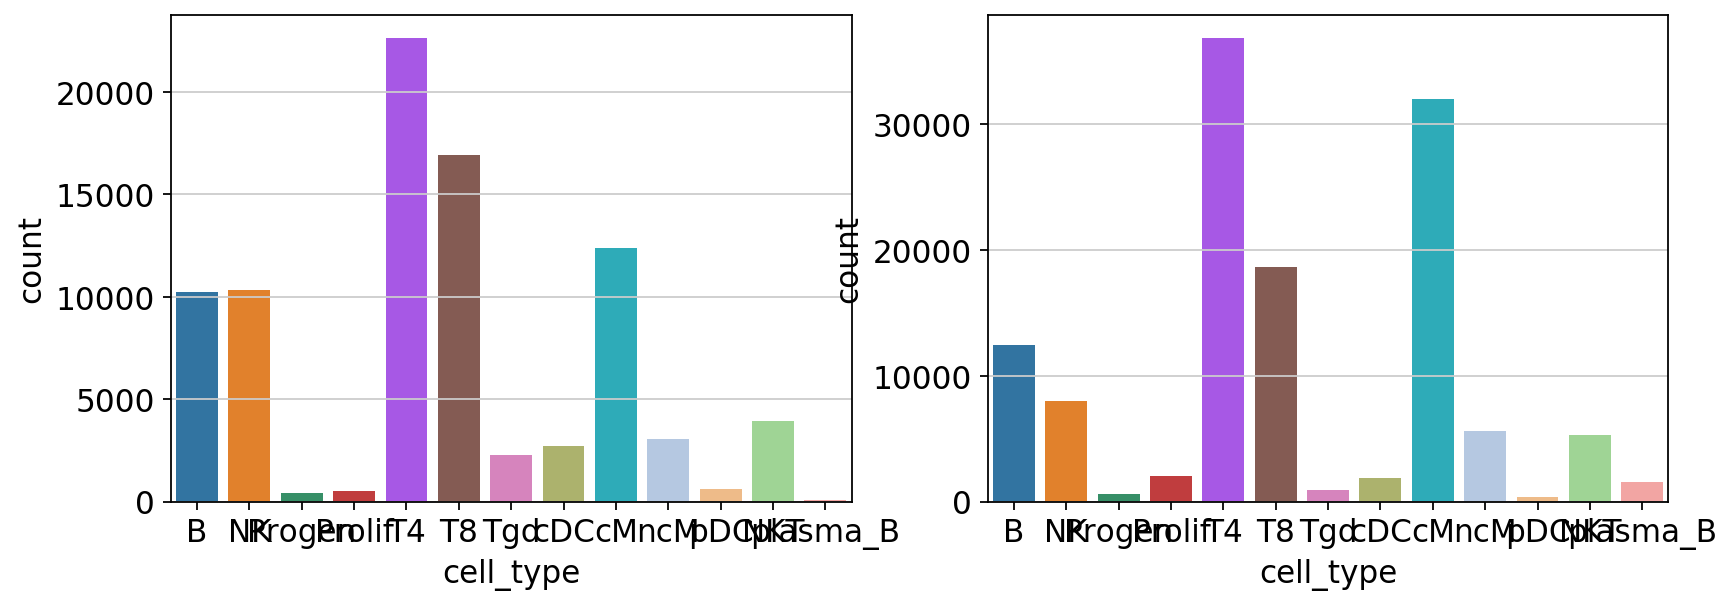

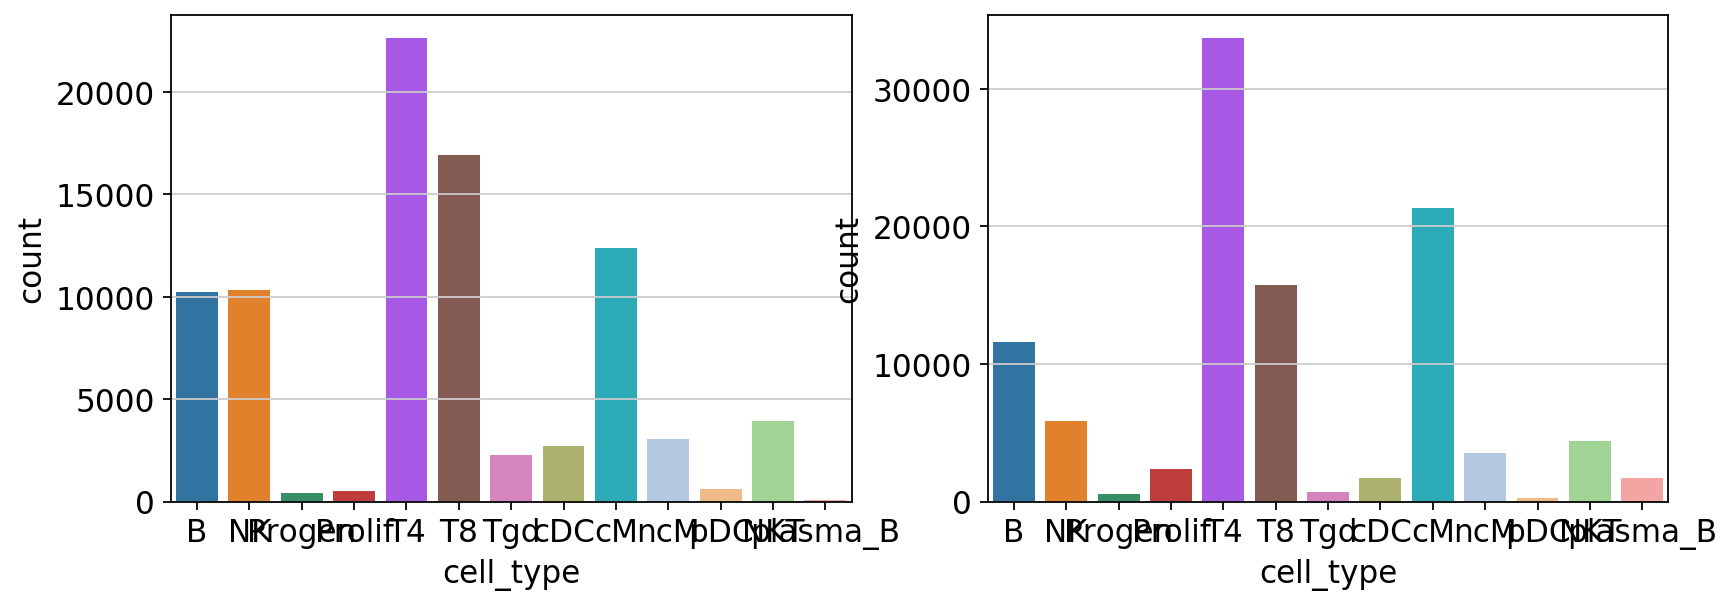

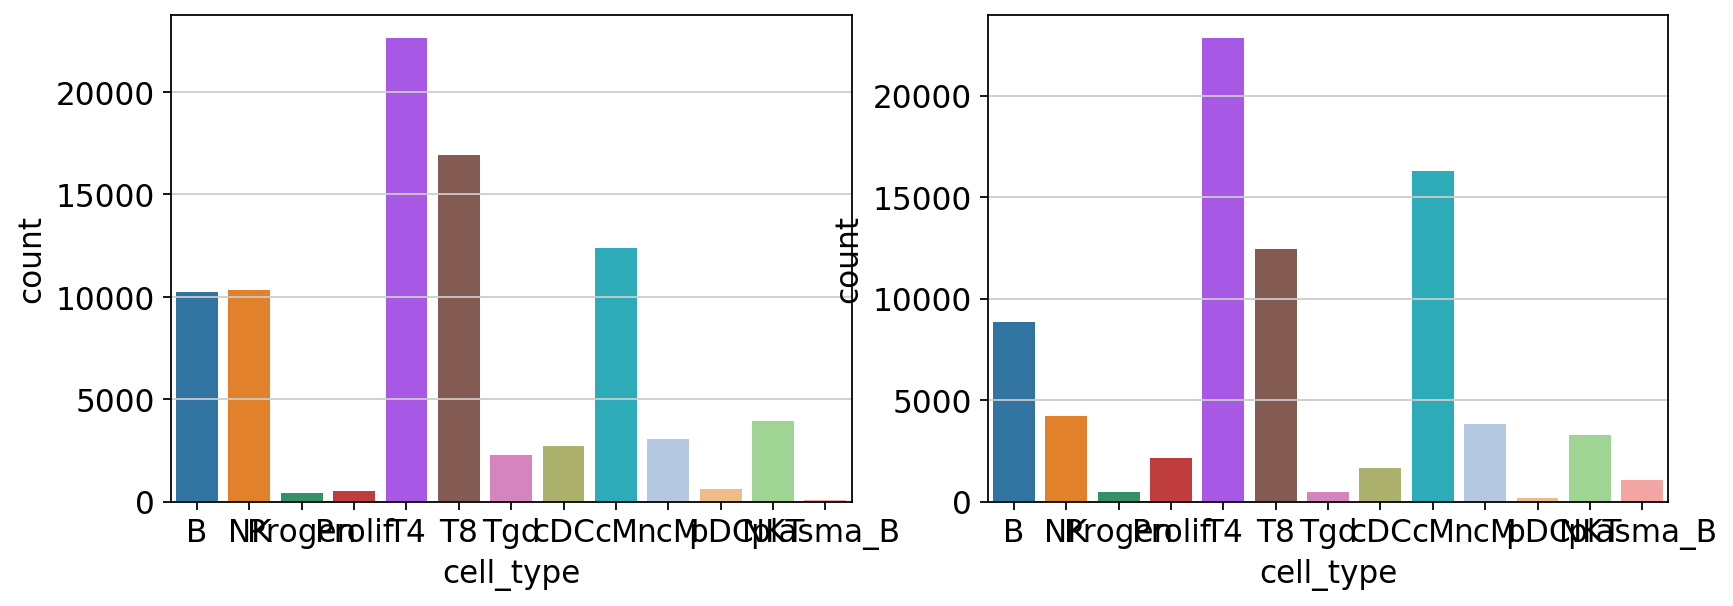

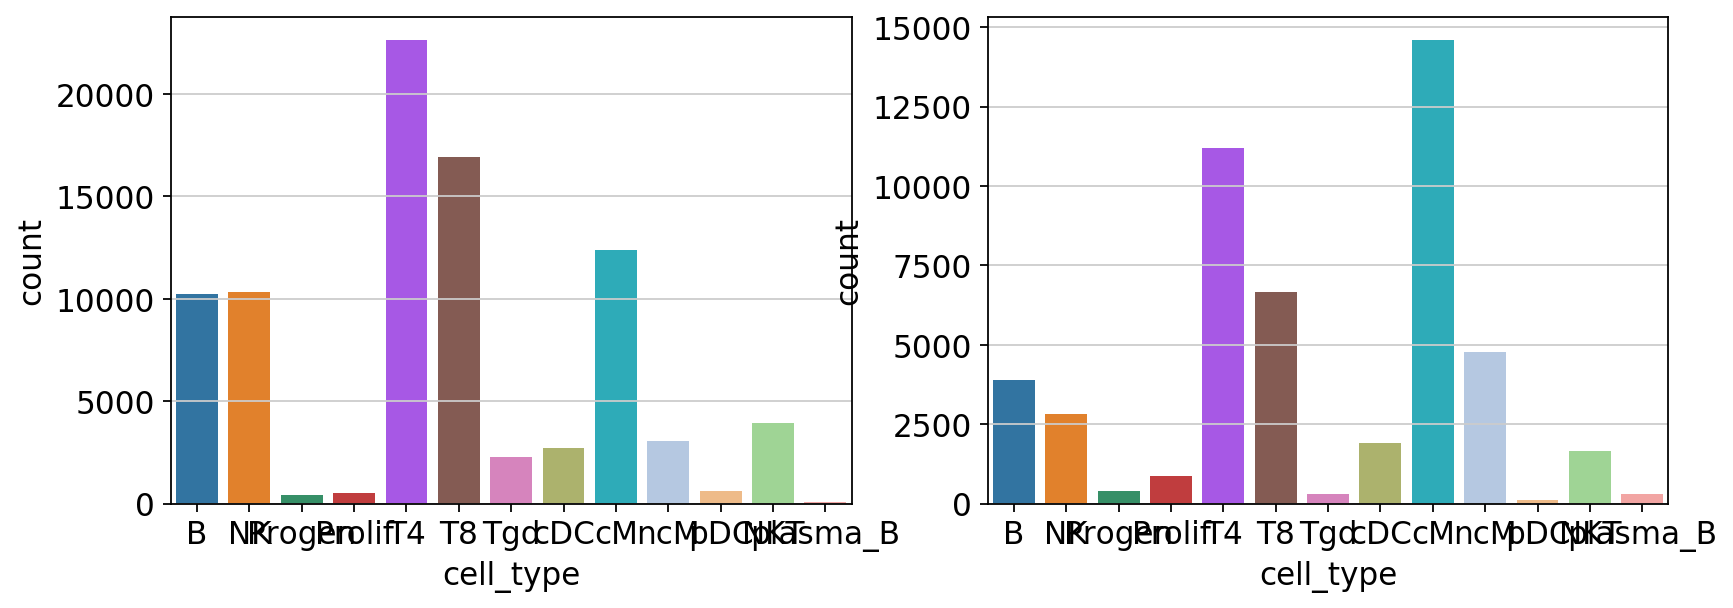

In [15]:
for a in adata_times:
    fig,ax = plt.subplots(1,2,figsize=(12,4))
    sns.countplot(x=a[a.obs['COVID_status'] == 0].obs['cell_type'],ax=ax[0])
    sns.countplot(x=a[a.obs['COVID_status'] == 1].obs['cell_type'],ax=ax[1])

In [16]:
# creating dictionary for all result dictionaries
memento_allCellTypes = {}

# iterating through each cell type
for cell_type in cell_types:
    
    # filtering out only this cell type
    adata_times_type = [a[a.obs['cell_type'] == cell_type] for a in adata_times]

    # creating dictionary to store results
    results_1d = {}
    i=0
    
    # iterating through each adata object, conducting memento and saving in dict
    for a in adata_times_type:
        
        # creating groups, include run and donor for batch effects
        a.obs['q_col'] = 0.15
        memento.create_groups(a, label_columns=['COVID_status','run','donor'], inplace=True, q_column='q_col')
        
        # computing size factor
        memento.compute_size_factors(a)
        
        # compute 1d moments
        memento.compute_1d_moments(a, inplace=True, 
            filter_genes=True, # Filter the AnnData object
            filter_mean_thresh=0.05, # minimum raw mean of each gene within a group for the gene to be considered 
            min_perc_group=.9) # percentage of groups that satisfy the condition for a gene to be considered.
        
        # conducting 1d ht
        memento.ht_1d_moments(a, formula_like='1 + COVID_status', cov_column='COVID_status', num_boot=5000, verbose=1, num_cpus=13)
        
        # saving annotated adata object
        a.write("../memento_results/all_cell_types/"+cell_type+"/adata_D"+timepoints[i]+"_"+cell_type+"_memento.h5ad")
        
        # computing and adding fdr corrected p-value
        result = memento.get_1d_ht_result(a)
        result['de_fdr'] = statsmodels.stats.multitest.fdrcorrection(result['de_pval'])[1]
        result['p/fdr'] = result['de_pval'] / result['de_fdr']
        
        # saving result as csv
        result.to_csv("../memento_results/all_cell_types/"+cell_type+"/memento_D"+timepoints[i]+"_"+cell_type+".csv")
        
        # adding result to dictionary
        results_1d[timepoints[i]] = result
        i = i+1
        
        assert 0 == 1
        
    # adding results to dictionary
    memento_allCellTypes[cell_type] = results_1d
    
# saving pickle file for overall dictionary
pickle.dump(memento_allCellTypes, open("../memento_results/all_cell_types/memento_allCellTypes.p", "wb" ))

Trying to set attribute `.obs` of view, copying.
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log
  rv[cond] = np.exp(np.log(var[cond]) - spline(np.log(mean[cond])))
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    5.4s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:   20.8s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   46.4s
Exception in thread QueueManagerThread:
Traceback (most recent call last):
  File "/data/home/anaconda3/envs/single_cell/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/data/home/anaconda3/envs/single_cell/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py", line 747, in _queue_manageme

KeyboardInterrupt: 

In [ ]:
a

In [ ]:
sns.countplot(x=a.obs['run'])

### Volcano Plots

In [ ]:
#run this is results_1d_cM is stored in memory
d0_results = results_1d_cM["0"]
d0_results = d0_results[d0_results['de_fdr'] <= 0.05]
d4_results = results_1d_cM["4"]
d4_results = d4_results[d4_results['de_fdr'] <= 0.05]
d7_results = results_1d_cM["7"]
d7_results = d7_results[d7_results['de_fdr'] <= 0.05]
d14_results = results_1d_cM["14"]
d14_results = d14_results[d14_results['de_fdr'] <= 0.05]

In [ ]:
#run this if you are reading results from csv
cutoff_thres = 1

d0_results = pd.read_csv("../memento_results/combined_runs/memento_D0.csv", index_col=0)
d0_results = d0_results[d0_results['de_fdr'] <= 0.05]
d0_cutoff = []
for de in d0_results['de_coef']:
    d0_cutoff.append(abs(de) >= cutoff_thres)
d0_results["de_cutoff"] = d0_cutoff

d4_results = pd.read_csv("../memento_results/combined_runs/memento_D4.csv", index_col=0)
d4_results = d4_results[d4_results['de_fdr'] <= 0.05]
d4_cutoff = []
for de in d4_results['de_coef']:
    d4_cutoff.append(abs(de) >= cutoff_thres)
d4_results["de_cutoff"] = d4_cutoff

d7_results = pd.read_csv("../memento_results/combined_runs/memento_D7.csv", index_col=0)
d7_results = d7_results[d7_results['de_fdr'] <= 0.05]
d7_cutoff = []
for de in d7_results['de_coef']:
    d7_cutoff.append(abs(de) >= cutoff_thres)
d7_results["de_cutoff"] = d7_cutoff

d14_results = pd.read_csv("../memento_results/combined_runs/memento_D14.csv", index_col=0)
d14_results = d14_results[d14_results['de_fdr'] <= 0.05]
d14_cutoff = []
for de in d14_results['de_coef']:
    d14_cutoff.append(abs(de) >= cutoff_thres)
d14_results["de_cutoff"] = d14_cutoff

In [ ]:
ISG_list = ['IL1B','IFI44L','MX1','IFI6','IFI44L','IFI44','CD14']

d0_isg = []
for gene in d0_results['gene']:
    d0_isg.append(gene in ISG_list)
d0_results["ISG"] = d0_isg

d4_isg = []
for gene in d4_results['gene']:
    d4_isg.append(gene in ISG_list)
d4_results["ISG"] = d4_isg

d7_isg = []
for gene in d7_results['gene']:
    d7_isg.append(gene in ISG_list)
d7_results["ISG"] = d7_isg

d14_isg = []
for gene in d14_results['gene']:
    d14_isg.append(gene in ISG_list)
d14_results["ISG"] = d14_isg

In [ ]:
# volcano plots annotated for ISGs
coloring = 'ISG'

colors = {True: 'orange', False: 'green'}

xs0 = list(d0_results['de_coef'][d0_results[coloring]])
ys0 = list(-np.log10(d0_results['p/fdr'][d0_results[coloring]]))
gs0 = d0_results['gene'][d0_results[coloring]]

xs4 = list(d4_results['de_coef'][d4_results[coloring]])
ys4 = list(-np.log10(d4_results['p/fdr'][d4_results[coloring]]))
gs4 = d4_results['gene'][d4_results[coloring]]

xs7 = list(d7_results['de_coef'][d7_results[coloring]])
ys7 = list(-np.log10(d7_results['p/fdr'][d7_results[coloring]]))
gs7 = d7_results['gene'][d7_results[coloring]]

xs14 = list(d14_results['de_coef'][d14_results[coloring]])
ys14 = list(-np.log10(d14_results['p/fdr'][d14_results[coloring]]))
gs14 = d14_results['gene'][d14_results[coloring]]


fig,ax = plt.subplots(2,2,figsize=(8,8), sharey=True, sharex=True)

ax[0,0].scatter(x = d0_results['de_coef'], 
            y = -np.log10(d0_results['p/fdr']), 
                c=d0_results[coloring].apply(lambda x: colors[x]))
for i, txt in enumerate(gs0):
    ax[0,0].annotate(s = txt, xy = (xs0[i],ys0[i]))
ax[0,0].set_title("D0")

ax[0,1].scatter(x = d4_results['de_coef'], 
            y = -np.log10(d4_results['p/fdr']), 
                c=d4_results[coloring].apply(lambda x: colors[x]))
for i, txt in enumerate(gs4):
    ax[0,1].annotate(s = txt, xy = (xs4[i],ys4[i]))
ax[0,1].set_title("D4")

ax[1,0].scatter(x = d7_results['de_coef'], 
            y = -np.log10(d7_results['p/fdr']), 
                c=d7_results[coloring].apply(lambda x: colors[x]))
for i, txt in enumerate(gs7):
    ax[1,0].annotate(s = txt, xy = (xs7[i],ys7[i]))
ax[1,0].set_title("D7")

ax[1,1].scatter(x = d14_results['de_coef'], 
            y = -np.log10(d14_results['p/fdr']), 
                c=d14_results[coloring].apply(lambda x: colors[x]))
for i, txt in enumerate(gs14):
    ax[1,1].annotate(s = txt, xy = (xs14[i],ys14[i]))
ax[1,1].set_title("D14")
fig.suptitle("Classical Monocyte DE Genes Healthy vs COVID19+")
fig.text(0.5, 0.04, 'logFC', ha='center')
fig.text(0.04, 0.5, '-log2(Pvalue/FDR)', va='center', rotation='vertical')

In [ ]:
plotdata = d0_results
xs = list(plotdata['de_coef'][plotdata['de_cutoff']])
ys = list(-np.log10(plotdata['p/fdr'][plotdata['de_cutoff']]))
gs = plotdata['gene'][plotdata['de_cutoff']]
colors = {True: 'red', False: 'blue'}

plt.scatter(x = plotdata['de_coef'], 
            y = -np.log10(plotdata['p/fdr']), 
            c=plotdata['de_cutoff'].apply(lambda x: colors[x]))
for i, txt in enumerate(gs):
    plt.annotate(s = txt, xy = (xs[i],ys[i]))
plt.title("D0 cMono DE Genes Healthy vs COVID+")
plt.ylabel("-log(Pvalue/FDR)")
plt.xlabel("logFC")

In [ ]:
plotdata = d4_results
xs = list(plotdata['de_coef'][plotdata['de_cutoff']])
ys = list(-np.log10(plotdata['p/fdr'][plotdata['de_cutoff']]))
gs = plotdata['gene'][plotdata['de_cutoff']]
colors = {True: 'red', False: 'blue'}

plt.scatter(x = plotdata['de_coef'], 
            y = -np.log10(plotdata['p/fdr']), 
            c=plotdata['de_cutoff'].apply(lambda x: colors[x]))
for i, txt in enumerate(gs):
    plt.annotate(s = txt, xy = (xs[i],ys[i]))
plt.title("D4 cMono DE Genes Healthy vs COVID+")
plt.ylabel("-log(Pvalue/FDR)")
plt.xlabel("logFC")

In [ ]:
plotdata = d7_results
xs = list(plotdata['de_coef'][plotdata['de_cutoff']])
ys = list(-np.log10(plotdata['p/fdr'][plotdata['de_cutoff']]))
gs = plotdata['gene'][plotdata['de_cutoff']]
colors = {True: 'red', False: 'blue'}

plt.scatter(x = plotdata['de_coef'], 
            y = -np.log10(plotdata['p/fdr']), 
            c=plotdata['de_cutoff'].apply(lambda x: colors[x]))
for i, txt in enumerate(gs):
    plt.annotate(s = txt, xy = (xs[i],ys[i]))
plt.title("D7 cMono DE Genes Healthy vs COVID+")
plt.ylabel("-log(Pvalue/FDR)")
plt.xlabel("logFC")

In [ ]:
plotdata = d14_results
xs = list(plotdata['de_coef'][plotdata['de_cutoff']])
ys = list(-np.log10(plotdata['p/fdr'][plotdata['de_cutoff']]))
gs = plotdata['gene'][plotdata['de_cutoff']]
colors = {True: 'red', False: 'blue'}

plt.scatter(x = plotdata['de_coef'], 
            y = -np.log10(plotdata['p/fdr']), 
            c=plotdata['de_cutoff'].apply(lambda x: colors[x]))
for i, txt in enumerate(gs):
    plt.annotate(s = txt, xy = (xs[i]+0.1,ys[i]+0.1), 
                 arrowprops=dict(arrowstyle='->'))
plt.title("D14 cMono DE Genes Healthy vs COVID+")
plt.ylabel("-log(Pvalue/FDR)")
plt.xlabel("logFC")

In [ ]:
# volcano plots annotated for DE cuttoff
coloring = 'de_cutoff'

colors = {True: 'red', False: 'blue'}

xs0 = list(d0_results['de_coef'][d0_results[coloring]])
ys0 = list(-np.log10(d0_results['p/fdr'][d0_results[coloring]]))
gs0 = d0_results['gene'][d0_results[coloring]]

xs4 = list(d4_results['de_coef'][d4_results[coloring]])
ys4 = list(-np.log10(d4_results['p/fdr'][d4_results[coloring]]))
gs4 = d4_results['gene'][d4_results[coloring]]

xs7 = list(d7_results['de_coef'][d7_results[coloring]])
ys7 = list(-np.log10(d7_results['p/fdr'][d7_results[coloring]]))
gs7 = d7_results['gene'][d7_results[coloring]]

xs14 = list(d14_results['de_coef'][d14_results[coloring]])
ys14 = list(-np.log10(d14_results['p/fdr'][d14_results[coloring]]))
gs14 = d14_results['gene'][d14_results[coloring]]


fig,ax = plt.subplots(2,2,figsize=(8,8), sharey=True, sharex=True)

ax[0,0].scatter(x = d0_results['de_coef'], 
            y = -np.log10(d0_results['p/fdr']), 
                c=d0_results[coloring].apply(lambda x: colors[x]))
for i, txt in enumerate(gs0):
    ax[0,0].annotate(s = txt, xy = (xs0[i],ys0[i]))
ax[0,0].set_title("D0")

ax[0,1].scatter(x = d4_results['de_coef'], 
            y = -np.log10(d4_results['p/fdr']), 
                c=d4_results[coloring].apply(lambda x: colors[x]))
for i, txt in enumerate(gs4):
    ax[0,1].annotate(s = txt, xy = (xs4[i],ys4[i]))
ax[0,1].set_title("D4")

ax[1,0].scatter(x = d7_results['de_coef'], 
            y = -np.log10(d7_results['p/fdr']), 
                c=d7_results[coloring].apply(lambda x: colors[x]))
for i, txt in enumerate(gs7):
    ax[1,0].annotate(s = txt, xy = (xs7[i],ys7[i]))
ax[1,0].set_title("D7")

ax[1,1].scatter(x = d14_results['de_coef'], 
            y = -np.log10(d14_results['p/fdr']), 
                c=d14_results[coloring].apply(lambda x: colors[x]))
for i, txt in enumerate(gs14):
    ax[1,1].annotate(s = txt, xy = (xs14[i],ys14[i]))
ax[1,1].set_title("D14")
fig.suptitle("Classical Monocyte DE Genes Healthy vs COVID19+")
fig.text(0.5, 0.04, 'logFC', ha='center')
fig.text(0.04, 0.5, '-log2(Pvalue/FDR)', va='center', rotation='vertical')

In [ ]:
d0_results[d0_results['de_cutoff']].sort_values('de_coef').to_csv("../memento_results/combined_runs/D0_highFC.csv")
d4_results[d4_results['de_cutoff']].sort_values('de_coef').to_csv("../memento_results/combined_runs/D4_highFC.csv")
d7_results[d7_results['de_cutoff']].sort_values('de_coef').to_csv("../memento_results/combined_runs/D7_highFC.csv")
d14_results[d14_results['de_cutoff']].sort_values('de_coef').to_csv("../memento_results/combined_runs/D14_highFC.csv")



Let's make sure I can actually read those csv files and recreate results so I don't lose work.

Text(0.5, 0, 'logFC')

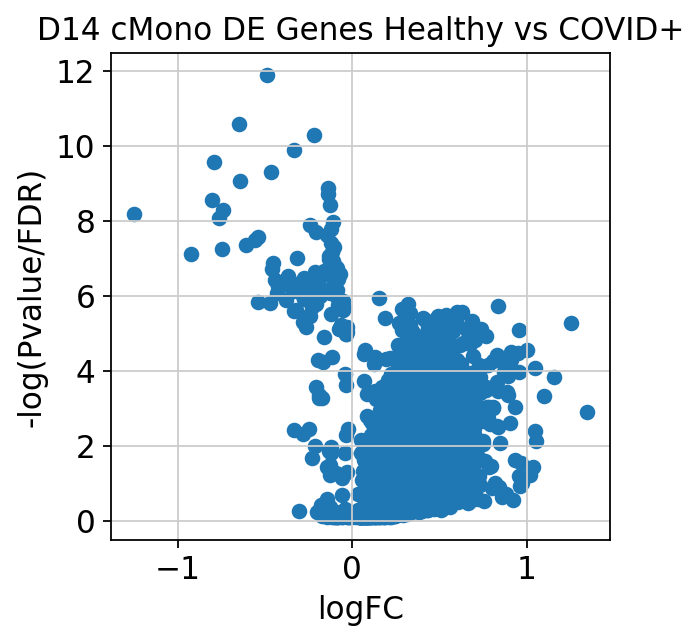

In [101]:
d14_read = pd.read_csv("../memento_results/combined_runs/memento_D14.csv", index_col=0)

d14_read['de_fdr'] = statsmodels.stats.multitest.fdrcorrection(d14_read['de_pval'])[1]
d14_read['p/fdr'] = d14_read['de_pval'] / d14_read['de_fdr']

d14_read = d14_read[d14_read['de_fdr'] <= 0.05]

plt.scatter(x = d14_read['de_coef'], 
            y = -np.log2(d14_read['p/fdr']))
plt.title("D14 cMono DE Genes Healthy vs COVID+")
plt.ylabel("-log(Pvalue/FDR)")
plt.xlabel("logFC")

## Heatmaps?

In [12]:
#read in the post-memento adata objects
adata0 = sc.read("../memento_results/combined_runs/adata_D0_cM_memento.h5ad")
adata4 = sc.read("../memento_results/combined_runs/adata_D4_cM_memento.h5ad")
adata7 = sc.read("../memento_results/combined_runs/adata_D7_cM_memento.h5ad")
adata14 = sc.read("../memento_results/combined_runs/adata_D14_cM_memento.h5ad")

In [25]:
result0 = memento.get_1d_ht_result(adata0)

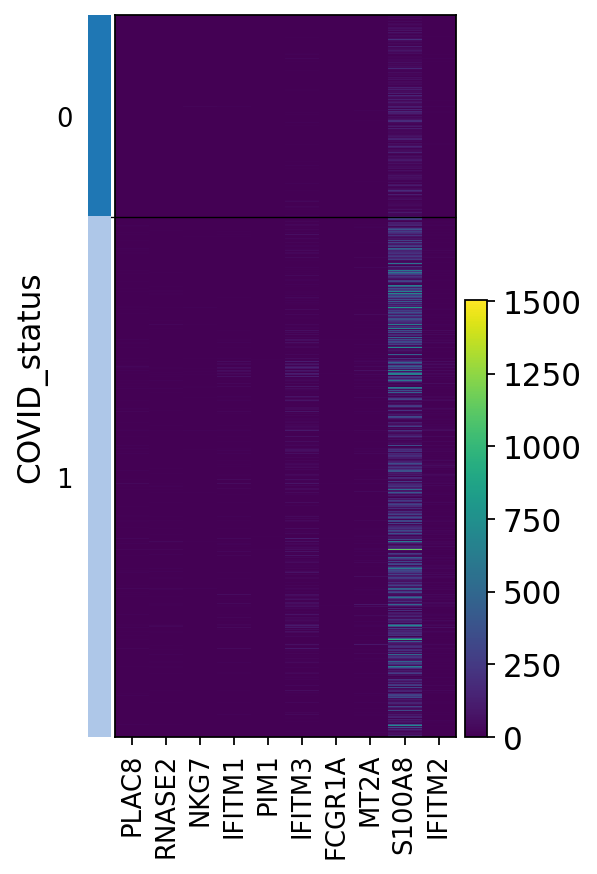

In [13]:
sc.pl.heatmap(adata0, d0_results.sort_values('de_coef', ascending=False)['gene'].head(10), cmap='viridis', groupby = 'COVID_status')

In [53]:
result0.sort_values('de_coef', ascending=False)['gene'].head(10)

774        PLAC8
2153      RNASE2
3014        NKG7
1595      IFITM1
1064        PIM1
          ...   
1016        IER3
474        CXCR4
1036    HLA-DQA1
3088      LGALS2
309         G0S2
Name: gene, Length: 3175, dtype: object

In [27]:
sns.heatmap(result0.sort_values('de_coef', ascending=False)['gene'].head(10))

IndexError: Inconsistent shape between the condition and the input (got (10, 1) and (10,))

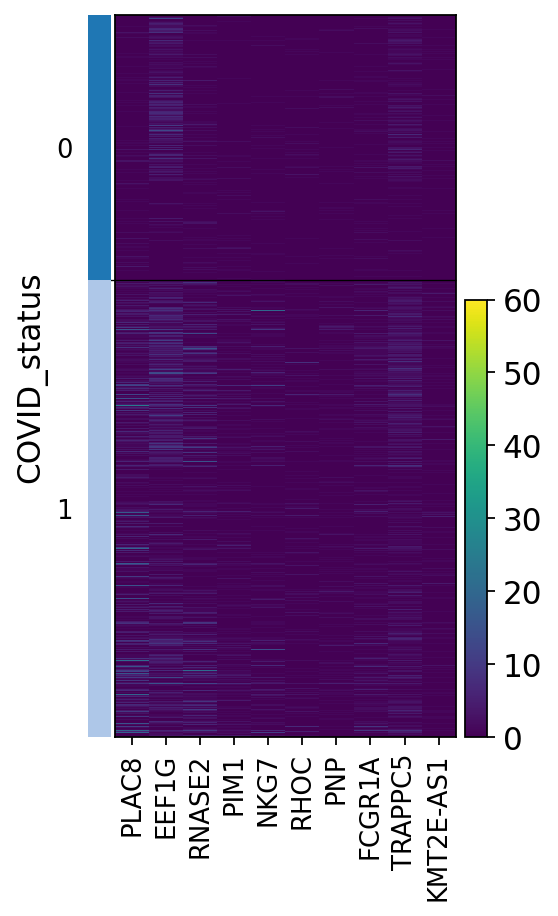

In [30]:
sc.pl.heatmap(adata4, d4_results.sort_values('de_coef', ascending=False)['gene'].head(10), cmap='viridis', groupby = 'COVID_status')

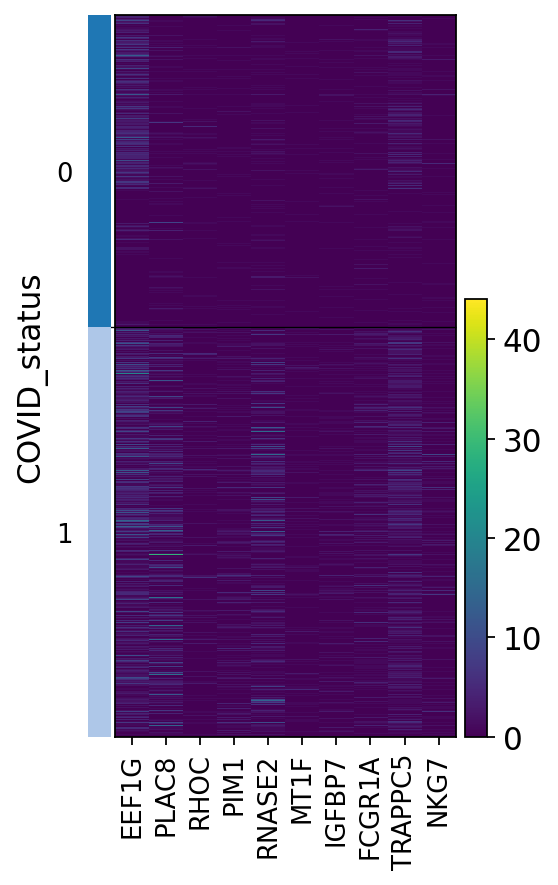

In [29]:
sc.pl.heatmap(adata7, d7_results.sort_values('de_coef', ascending=False)['gene'].head(10), cmap='viridis', groupby = 'COVID_status')

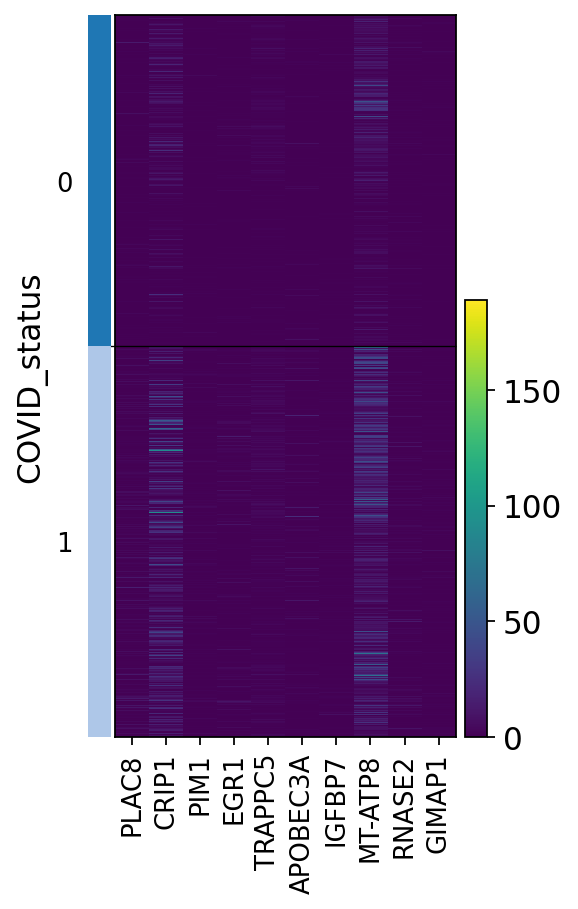

In [35]:
sc.pl.heatmap(adata14, d14_results.sort_values('de_coef', ascending=False)['gene'].head(10), cmap='viridis', groupby = 'COVID_status')

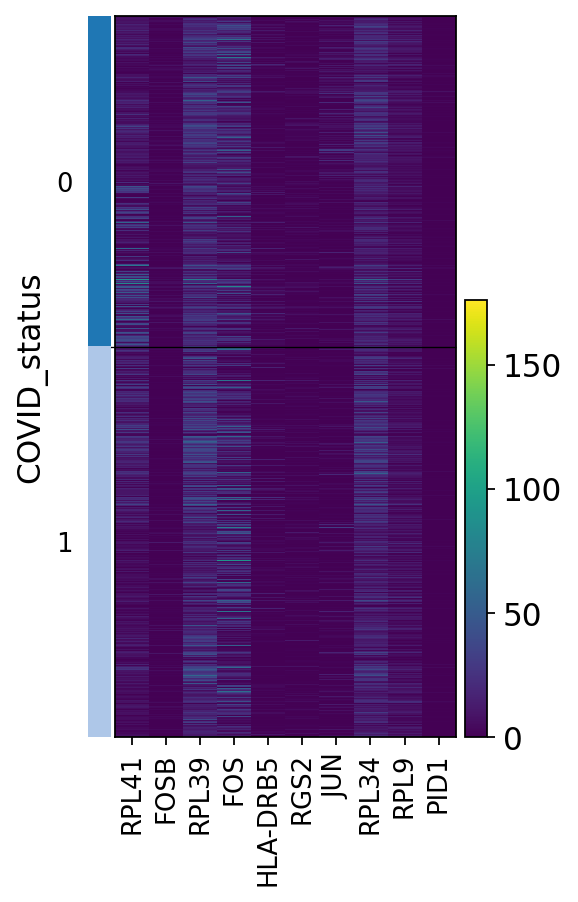

In [33]:
sc.pl.heatmap(adata14, d14_results.sort_values('de_fdr')['gene'].head(10), cmap='viridis', groupby = 'COVID_status')

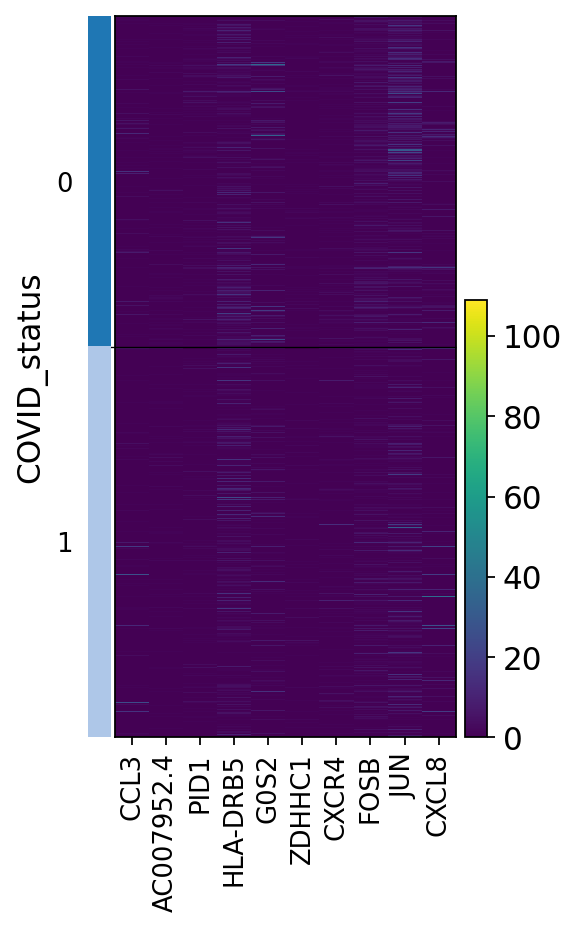

In [36]:
sc.pl.heatmap(adata14, d14_results.sort_values('de_coef')['gene'].head(10), cmap='viridis', groupby = 'COVID_status')

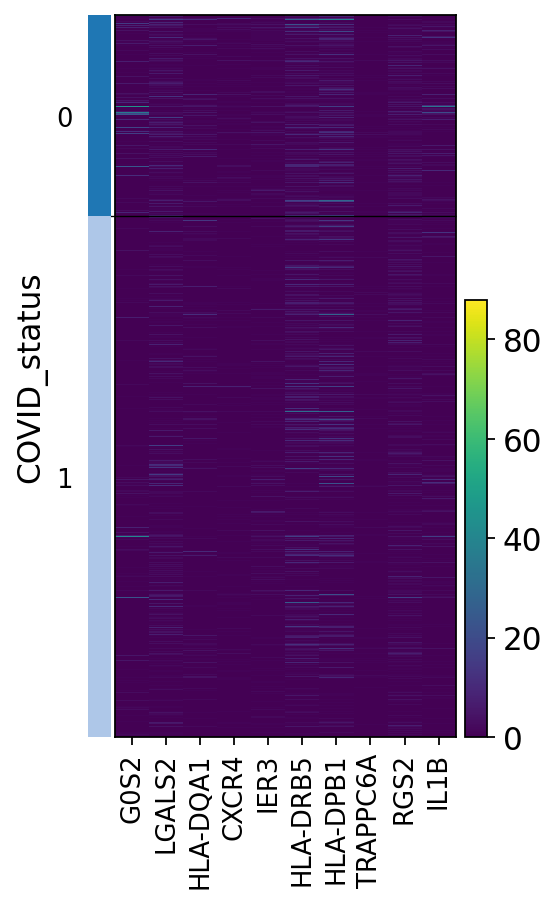

In [37]:
sc.pl.heatmap(adata0, d0_results.sort_values('de_coef')['gene'].head(10), cmap='viridis', groupby = 'COVID_status')

In [30]:
adata4_nh = adata4[adata4.obs['COVID_status']=="1"]
adata7_nh = adata7[adata7.obs['COVID_status']=="1"]
adata14_nh = adata14[adata14.obs['COVID_status']=="1"]

In [34]:
adata0to14 = adata0.concatenate(adata4_nh, adata7_nh, adata14_nh)

In [37]:
adata0to14.obs.loc[adata0to14.obs['COVID_status'] == '0', 'timepoint'] = "Healthy"
adata0to14.obs['timepoint'].unique()

array(['Healthy', '0', '4', '7', '14'], dtype=object)

In [84]:
top_upgenes = d0_results.query('de_coef >= 1').sort_values('de_coef')['gene']
top_upgenes.append(d4_results.query('de_coef >= 1').sort_values('de_coef')['gene'])
top_upgenes.append(d7_results.query('de_coef >= 1').sort_values('de_coef')['gene'])
top_upgenes.append(d14_results.query('de_coef >= 1').sort_values('de_coef')['gene'])
top_upgenes

698     TNFSF10
2062       OAS1
657       PARP9
2445       MT1F
62         IFI6
2115     EPSTI1
1594     IFITM2
211      S100A8
2444       MT2A
193      FCGR1A
1596     IFITM3
1064       PIM1
1595     IFITM1
3014       NKG7
2153     RNASE2
774       PLAC8
Name: gene, dtype: object

In [82]:
top_upgenes = top_upgenes[top_upgenes != "PARP9"]
top_upgenes = top_upgenes[top_upgenes != "MT1F"]

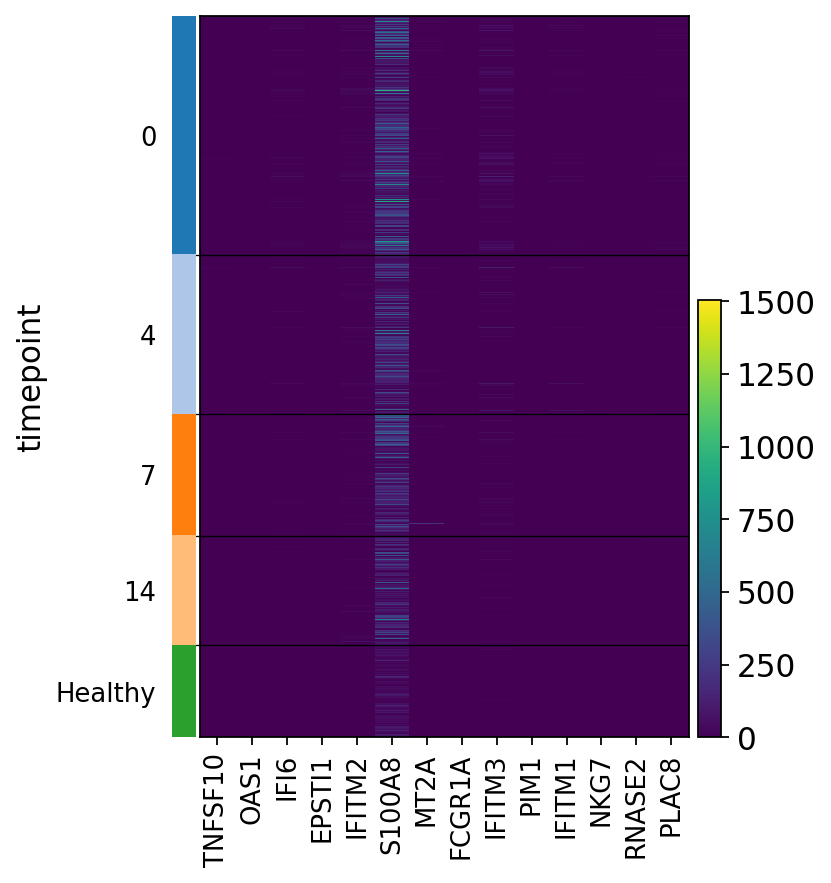

In [83]:
sc.pl.heatmap(adata0to14, top_upgenes, cmap='viridis', groupby = 'timepoint')

In [47]:
up_genes = d0_results.query('de_coef >= 1')['gene']
up_genes = up_genes.append(d4_results.query('de_coef >= 1')['gene'])
up_genes = up_genes.append(d7_results.query('de_coef >= 1')['gene'])
up_genes = up_genes.append(d14_results.query('de_coef >= 1')['gene'])

up_genes = list(up_genes.unique())
up_genes

['IFI6',
 'FCGR1A',
 'S100A8',
 'PARP9',
 'TNFSF10',
 'PLAC8',
 'PIM1',
 'IFITM2',
 'IFITM1',
 'IFITM3',
 'OAS1',
 'EPSTI1',
 'RNASE2',
 'MT2A',
 'MT1F',
 'NKG7',
 'RHOC',
 'EEF1G',
 'PNP',
 'TRAPPC5',
 'IGFBP7',
 'F13A1',
 'CRIP1',
 'ECH1',
 'LAIR1',
 'EGR1',
 'GIMAP1',
 'APOBEC3A',
 'MT-ATP8']

In [51]:
heat_data = pd.DataFrame()
heat_data.append(results1)

In [ ]:
sc.heatmap()